# IPKISS Euler bend

The goal is to code a 90° Euler bend PCell for a 1μm wide waveguide with a 10μm minimum bend radius in IPKISS. While doing this, I'll go over all the steps I took.

## Imports

In [1]:
%matplotlib inline
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import fresnel

import technologies.silicon_photonics
import ipkiss3.all as i3

## Background

The Euler bend is based on the Euler spiral:

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Euler_spiral.svg/1024px-Euler_spiral.svg.png width=300>

Euler spirals are used in integrated photonics to smoothen the abrupt change of curvature and reduce coupling to radiation modes.

The Euler bend is defined as the curve for which the radius of curvature is inversely proportional to the length of the curve:
$$
\begin{align*}
\frac{1}{R} = \frac{d\theta}{ds} := Cs
\end{align*}
$$
this means that, for every distance on the curve $s$, we have:

$$
\begin{align*}
\frac{1}{Rs} = C = \frac{1}{R_L L}
\end{align*}
$$

Where $R_L$ is defined as the radius of curvature at the end of the curve (after the final curve length of L).

We can thus write:
$$
\begin{align}
\frac{d\theta}{ds} = \frac{s}{R_L L} \Rightarrow \theta = \frac{s^2}{2 R_L \theta}
\end{align},
$$

which implies that the toal length of the Euler bend equals
$$
\begin{align}
L = 2 R_L \theta
\end{align}.
$$

Moreover, for every point $(x,y)$ on the curve, we must have that
$$
\begin{align}
x &= \int_0^s \cos(\theta) ds \\
&= \int_0^s \cos\left(\frac{s^2}{2 R_L L}\right)ds \\
&= \sqrt{\pi R_L L} C\left(\frac{s}{\sqrt{\pi R_L L}}\right)
\end{align}
$$

and similarly:
$$
\begin{align}
y &= \sqrt{\pi R_L L} S\left(\frac{s}{\sqrt{\pi R_L L}}\right)
\end{align}
$$

with $C$ and $S$ the Fresnel functions.

## Asymmetric Euler bend 
Naively, we could implement this as follows:

In [2]:
def euler_bend_asymmetric(R=10, theta=np.pi/2, num_points=1000):
    """
    Args:
        R (float): final (minimal) bend radius
        theta (float): final angle
        num_points (int): resolution of the shape
    """
    L = 2 * R * theta # total length of the Euler bend
    s = np.linspace(0, L, num_points//2)
    f = np.sqrt(np.pi * R * L) + 1e-18 # for numerical stability
    y, x = fresnel(s / f)
    return f*x, f*y

However, when we plot this, we see this shape is not symmetric:

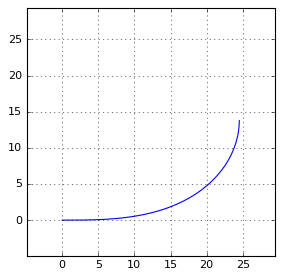

In [3]:
R = 10
theta = np.pi/2

x_asym, y_asym = euler_bend_asymmetric(R=R, theta=theta)

plt.axis('scaled')
m = max(max(x_asym), max(y_asym))
plt.xlim(-.2*m, 1.2*m)
plt.ylim(-.2*m, 1.2*m)
plt.grid()
plt.plot(x_asym,y_asym)
plt.show()

this means that light coming from $(0,0)$ will have a smooth transition and light from $(x_L, y_L)$ won't! Ideally we would like to have this propagation be symmetric. Making the Euler bend symmetric, however, is not so difficult; one can define a **half** euler bend (i.e, with length $R\theta$) and concatenate this half bend with its mirror image:

In [4]:
def euler_bend_symmetric(R=10, theta=np.pi/2, num_points=1000):
    """
    Args:
        R (float): minimal bend radius (at the middle of the bend)
        theta (float): final angle
        num_points (int): resolution of the shape
    """
    L = 2 * R * theta / 2
    s = np.linspace(0, L, num_points//2)
    f = np.sqrt(np.pi * R * L) + 1e-18 # for numerical stability
    y1, x1 = fresnel(s / f)
    # first, rotate by the final angle
    x2, y2 = np.dot(np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]), np.stack([x1, y1], 0))
    # then, flip along the x-axis (and reverse direction of the curve):
    x2, y2 = -x2[::-1], y2[::-1]
    # then translate from (x2[0], y2[0]) to (x1[-1], y1[-1])
    x2, y2 = x2 - x2[0] + x1[-1], y2 - y2[0] + y1[-1]
    x = f * np.concatenate([x1, x2], 0)
    y = f * np.concatenate([y1, y2], 0)
    return x, y

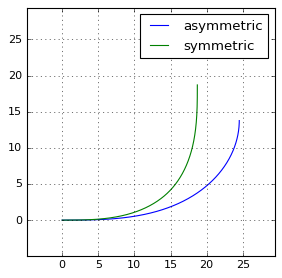

In [5]:
x_sym, y_sym = euler_bend_symmetric(R=R, theta=theta)

plt.axis('scaled')
m = max(max(x_sym), max(y_sym), max(x_asym), max(y_asym))
plt.xlim(-.2*m, 1.2*m)
plt.ylim(-.2*m, 1.2*m)
plt.grid()
plt.plot(x_asym, y_asym, label="asymmetric")
plt.plot(x_sym, y_sym, label="symmetric")
plt.legend()
plt.show()

Note that both have the same length:

In [6]:
def length(x, y):
    dx = x[1:] - x[:-1]
    dy = y[1:] - y[:-1]
    return np.sum(np.sqrt(dx**2 + dy**2))

print(length(x_sym, y_sym))
print(length(x_asym, y_asym))

31.4159222122
31.4159092411


The length also corresponds to the expected length, i.e $L=2R\theta$:

In [7]:
2 * R * theta

31.41592653589793

## Make Euler shape end at 40,30

As an extra bonus, we could in fact also define the Euler bend by the point the end of the bend needs to end up. To do this, we can use the following relation:
$$
\theta = 2\mathrm{arctan}(\frac{y_L}{x_L})
$$
i.e. the final angle of the euler bend is twice the angle made by straight line connecting the starting point and the end point of the bend and the x-axis.

We can now simply create an euler bend with bend radius $R=1$ and $\theta$ found by the above equation. By then scaling the obtained bend, we obtain the final result:

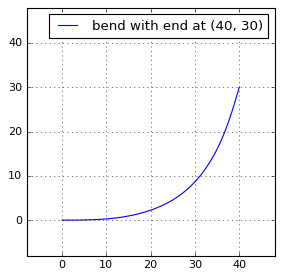

In [8]:
X, Y = 40.0, 30.0
theta = 2*np.arctan2(Y, X)
x, y = euler_bend_symmetric(R=1, theta=theta)
x *= X/x[-1]
y *= Y/y[-1]

plt.axis('scaled')
m = max(max(x), max(y))
plt.xlim(-.2*m, 1.2*m)
plt.ylim(-.2*m, 1.2*m)
plt.grid()
plt.plot(x, y, label="bend with end at (%.0f, %.0f)"%(X,Y))
plt.legend()
plt.show()

## IPKISS Component


In [9]:
class EulerBend(i3.PCell):
    """ An Euler Bend for IPKISS """

    _name_prefix = "EULER_BEND"

    trace_template = i3.WaveguideTemplateProperty(
        doc="trace template for the waveguide"
    )
    def _default_trace_template(self):
        return i3.TECH.PCELLS.WG.DEFAULT

    waveguide = i3.ChildCellProperty(doc="waveguide")
    def _default_waveguide(self):
        return i3.RoundedWaveguide(trace_template=self.trace_template)

    class Layout(i3.LayoutView):
        """ Layout for the IPKISS Euler Bend """

        min_radius = i3.PositiveNumberProperty(doc="minimum Euler bend radius")
        def _default_min_radius(self):
            if self.end_point is None:
                return 10
            x, y = self.end_point
            theta = 2 * np.arctan2(
                y, x
            )  # the final angle is twice the angle between start and finish.
            x1, y1 = euler_bend_symmetric(R=1, theta=theta, num_points=4)
            return x / x1[-1]

        end_angle = i3.PositiveNumberProperty(doc="angle (in degrees) at the end of the Euler bend.")
        def _default_end_angle(self):
            if self.end_point is None:
                return 90
            x, y = self.end_point
            return 2 * np.arctan2(y, x) * i3.RAD2DEG

        num_points = i3.PositiveNumberProperty(
            doc="resolution of the euler bend shape.",
            default=1000,
        )

        end_point = i3.Coord2Property(
            doc=(
                "(optional) coordinates of the end of the Euler bend.\n"
                "if given, this will override `min_radius` and `end_angle`."
            ),
            default=None,
        )
        
        core_width = i3.PositiveNumberProperty(
            doc="default core width of the waveguide",
            default=i3.TECH.WG.WIRE_WIDTH,
        )
        
        cladding_width = i3.PositiveNumberProperty(
            doc="default cladding width of the waveguide",
            default=i3.TECH.WG.CLADDING_WIDTH,
        )

        def _default_trace_template(self):
            trace = self.cell.trace_template.get_default_view(i3.LayoutView)
            trace.set(
                core_width=self.core_width,
                cladding_width=self.cladding_width,
            )
            return trace

        def _default_waveguide(self):
            waveguide = self.cell.waveguide.get_default_view(i3.LayoutView)
            x, y = euler_bend_symmetric(
                R=self.min_radius,
                theta=self.end_angle * i3.DEG2RAD,
                num_points=self.num_points,
            )
            center_line = zip(x,y)
            waveguide.set(
                shape=center_line,
                trace_template=self.trace_template,
                bend_radius=self.min_radius,
            )
            return waveguide

        def _generate_instances(self, insts):
            insts += i3.SRef(reference=self.waveguide)
            return insts
        
        def _generate_ports(self, ports):
            ports += self.waveguide.ports
            return ports

So to finalize... the goal was to code a 90° Euler bend with a 1μm wide waveguide width and a 10μm minimum bend radius:

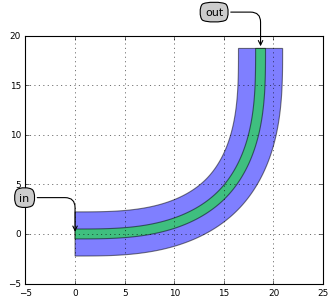

In [10]:
cell = EulerBend()
layout = cell.Layout(end_angle=90, core_width=1, min_radius=10)
layout.visualize(annotate=True, show=False)
plt.grid()
plt.show()

As an extra addition, we added the functionality to make the euler bend up at any point we want. For example, this is how we could make an Euler bend which ends up at $(30,30)$:

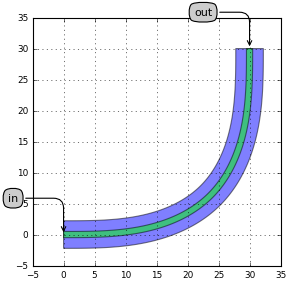

In [11]:
layout = cell.Layout(end_point=(30,30), core_width=1)
layout.visualize(annotate=True, show=False)
plt.grid()
plt.show()